# Yankees - Ticketing
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 25, 2022

## Hypothesis
We can help teams predict who will buy a single ticket to the next game based on the historical data we have on that fan. This also requires engineering a new feature (isNextGameBuyer) in order to make a prediction on if the fan will buy a ticket to the next game or not.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '52.44.171.130' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 53 # Yankees

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrYankees].[ds].[getPropensityEventScoring] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"]) 

CNXN.commit()
cursor.close()

df.shape

(1075402, 44)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1075402 entries, 0 to 1075401
Data columns (total 44 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   lkupClientId            1075402 non-null  int64  
 1   dimCustomerMasterId     1075402 non-null  int64  
 2   dimEventId              1075402 non-null  int64  
 3   inMarket                1075402 non-null  bool   
 4   customerNumber          1075402 non-null  object 
 5   year                    1075402 non-null  int64  
 6   productGrouping         1075402 non-null  object 
 7   totalSpent              1075402 non-null  float64
 8   recentDate              1075402 non-null  object 
 9   attendancePercent       1075402 non-null  float64
 10  renewedBeforeDays       1075402 non-null  int64  
 11  isBuyer                 1075402 non-null  object 
 12  source_tenure           1075402 non-null  int64  
 13  tenure                  1075402 non-null  int64  
 14  di

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = ["dimCustomerMasterId",
        "inMarket",
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "distToVenue",
        "totalGames",
        "recency",
        "NumberofGamesPerSeason",
        "isNextGameBuyer",
        "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (758157, 12)
Unseen Data For Predictions: (133792, 12)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextGameBuyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","year"],
    silent=True,
    verbose=False,
    numeric_features=[
        "inMarket",
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "distToVenue",
        "totalGames",
        "recency",
        "NumberofGamesPerSeason"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["gbc", "lightgbm", "lr", "rf", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9726,0.9458,0.3695,0.7095,0.4857,0.4731,0.4999,11.6740
lightgbm,Light Gradient Boosting Machine,0.9718,0.9443,0.3564,0.6895,0.4697,0.4568,0.4833,1.2910
rf,Random Forest Classifier,0.9696,0.9067,0.4048,0.5966,0.4823,0.4672,0.4766,23.1250
gbc,Gradient Boosting Classifier,0.9695,0.9326,0.2982,0.6371,0.4062,0.3926,0.4227,15.0190
lr,Logistic Regression,0.9657,0.8583,0.1006,0.5579,0.1704,0.1614,0.2267,2.3460


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9725,0.9433,0.3468,0.7261,0.4694,0.4571,0.4903
1,0.9717,0.9462,0.3699,0.6770,0.4784,0.4652,0.4877
2,0.9734,0.9476,0.3816,0.7306,0.5014,0.4891,0.5165
3,0.9722,0.9455,0.3586,0.7010,0.4745,0.4617,0.4893
4,0.9729,0.9464,0.3751,0.7174,0.4926,0.4801,0.5069
5,0.9731,0.9500,0.3882,0.7137,0.5029,0.4903,0.5145
6,0.9723,0.9438,0.3788,0.6904,0.4892,0.4762,0.4990
7,0.9724,0.9442,0.3647,0.7058,0.4809,0.4682,0.4954
8,0.9719,0.9436,0.3482,0.6994,0.4650,0.4522,0.4815
9,0.9735,0.9478,0.3826,0.7338,0.5029,0.4907,0.5184


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(183453, 44)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,dimEventId,inMarket,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,...,outbound_phonecall,phonecall,text,unknown,credits_after_refund,NumberofGamesPerSeason,isNextGameBuyer,Label,Score_0,Score_1
891949,53,74,1368,True,19858775,2021,Online Individual Game,144.0,1970-01-01,0.0,...,0,0,0,0,0.0,94,0,0,0.9863,0.0137
891950,53,136,168,False,23191863,2021,Online Individual Game,126.0,2021-05-08,1.0,...,0,0,0,0,0.0,94,0,0,0.9976,0.0024
891951,53,1314,1341,True,11896281,2021,Other,133.0,1970-01-01,0.0,...,0,0,0,0,0.0,94,0,0,0.9967,0.0033
891952,53,1855,152,True,14832348,2021,Online Individual Game,120.0,2021-10-02,1.0,...,0,0,0,0,0.0,94,0,0,0.9999,0.0001
891953,53,2040,1071,False,21858936,2021,Online Individual Game,198.0,2021-04-30,1.0,...,0,0,0,0,0.0,94,0,0,0.9912,0.0088


In [11]:
new_predictions["Label"].value_counts()

0    182879
1       574
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    179093
(0.2, 0.4]         3218
(0.4, 0.6]          849
(0.6, 0.8]          162
(0.8, 1.0]          131
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

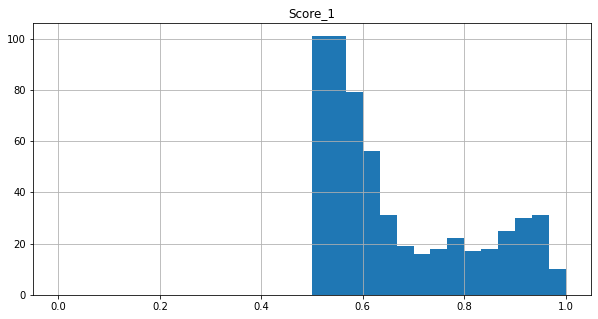

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

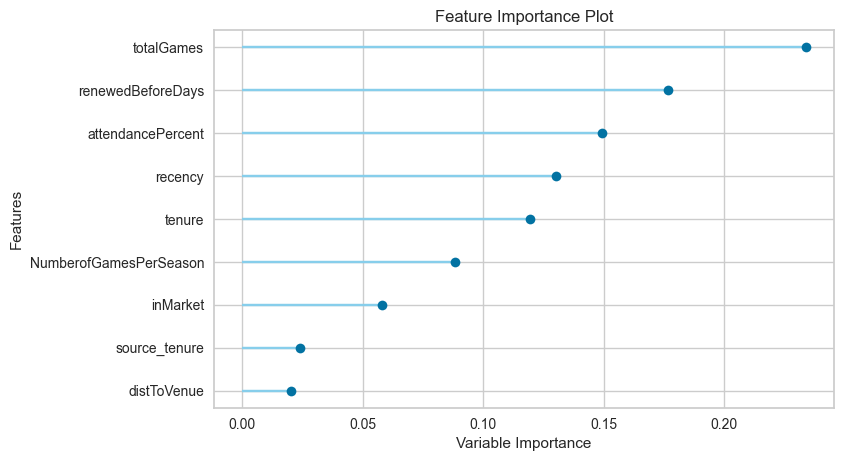

In [14]:
plot_model(best_model, plot='feature')

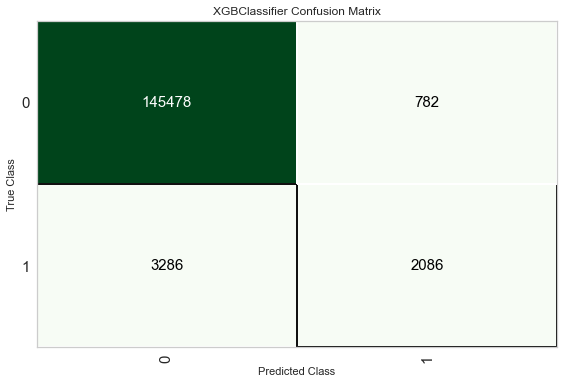

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above

* The distribtution looks normal (as expected)
* The model makes a lot more predictions of customers who won't buy

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?

* We should ask CS/CI what they think the most significant factor towards a next game buyer is.